<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/FastAI_2022_Fastbook_Tabular_Runthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Runthrough of Fastbook Chapter 9 - Tabular Modeling Deep Dive**

## Setup

In [1]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.4 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import dtreeviz as dtv
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
# Kaggle
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
# Credentials storage
# Using Kaggle API key
creds = '{"username":"bachaudhry","key":"f8e0ee26f34cb0d3e4eccd774de62f63"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [4]:
if iskaggle:
  path = Path('../input/bluebook-for-bulldozers')
else:
  import zipfile, kaggle
  path = Path('bluebook-for-bulldozers')
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 48.4M/48.4M [00:00<00:00, 82.1MB/s]


## Data Assessment

In [5]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [8]:
# We will need to order the categories of product size
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

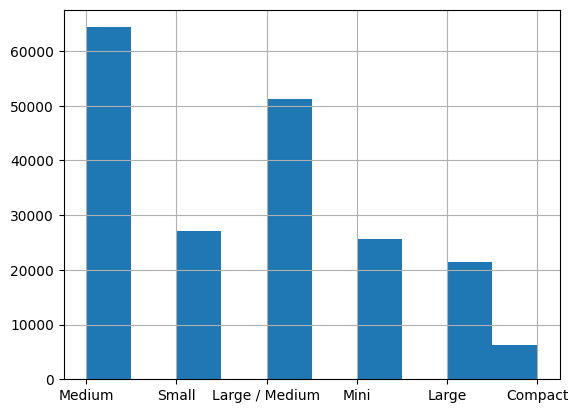

In [9]:
df['ProductSize'].hist();

In [10]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

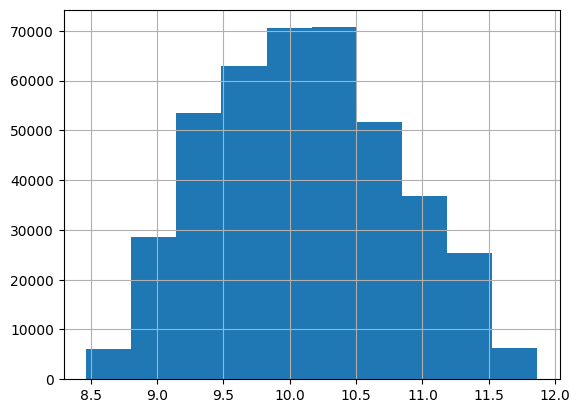

In [11]:
df['SalePrice'].hist();

# Processing Data

In [12]:
# Handling dates using the FastAI tabular library which is super handy imo
# This will add a number of meta data columns by treating dates as ordinal values
# In order words, providing additional categorical variables for the model.
df = add_datepart(df, 'saledate')
df.info()

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 65 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  object  
 10  fiBaseModel               412698 non-null  object  
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [13]:
# Doing the same for the test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 1834 non-null   object 
 8   fiModelDesc               12457 non-null  object 
 9   fiBaseModel               12457 non-null  object 
 10  fiSecondaryDesc           8482 non-null   object 
 11  fiModelSeries             2006 non-null   object 
 12  fiModelDescriptor         3024 non-null   object 
 13  ProductSize               6048 non-null   object 
 14  fiProd

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [14]:
# These are all the columns which are dealing with dates
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [15]:
# Using additional FastAI functions, which we can pass in lists
procs = [Categorify, FillMissing]

The date range in the test set covers a six month period from May 2012, which is later in time than dates in the training set.

Our validation set will need to cover data from November 2011 in order to be similar to the test set. Data prior to November 2011 will be part of the training set.

In [16]:
# Creating training and validation splits based on Sales dates and months
cond = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
# We will create a tuple of lists which will then be passed to TabularPandas
# to identify continuous and categorical columns
splits = (list(train_idx), list(valid_idx))

In [17]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
cont, cat

(['SalesID',
  'MachineID',
  'ModelID',
  'datasource',
  'auctioneerID',
  'YearMade',
  'MachineHoursCurrentMeter',
  'saleYear',
  'saleMonth',
  'saleWeek',
  'saleDay',
  'saleDayofweek',
  'saleDayofyear',
  'saleElapsed'],
 ['UsageBand',
  'fiModelDesc',
  'fiBaseModel',
  'fiSecondaryDesc',
  'fiModelSeries',
  'fiModelDescriptor',
  'ProductSize',
  'fiProductClassDesc',
  'state',
  'ProductGroup',
  'ProductGroupDesc',
  'Drive_System',
  'Enclosure',
  'Forks',
  'Pad_Type',
  'Ride_Control',
  'Stick',
  'Transmission',
  'Turbocharged',
  'Blade_Extension',
  'Blade_Width',
  'Enclosure_Type',
  'Engine_Horsepower',
  'Hydraulics',
  'Pushblock',
  'Ripper',
  'Scarifier',
  'Tip_Control',
  'Tire_Size',
  'Coupler',
  'Coupler_System',
  'Grouser_Tracks',
  'Hydraulics_Flow',
  'Track_Type',
  'Undercarriage_Pad_Width',
  'Stick_Length',
  'Thumb',
  'Pattern_Changer',
  'Grouser_Type',
  'Backhoe_Mounting',
  'Blade_Type',
  'Travel_Controls',
  'Differential_Type',
  

In [18]:
# Tabular Pandas automatically includes train and valid attributes
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train), len(to.valid)

(404710, 7988)

In [19]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [20]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [21]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'],
                    [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [22]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [23]:
# classes allows us to see the mappings of categorical numberings
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [24]:
to.classes['ProductGroup']

['#na#', 'BL', 'MG', 'SSL', 'TEX', 'TTT', 'WL']

In [25]:
# Saving the file in local pickle format to speed things up.
save_pickle(path/'to.pkl', to)

# Creating a Decision Tree

In [26]:
# Loading our pickle file for speedier processing
to = load_pickle(path/'to.pkl')

In [27]:
# Using previously created indices for our training and validation sets
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
xs.shape, y.shape, valid_xs.shape, valid_y.shape

((404710, 66), (404710,), (7988, 66), (7988,))

In [28]:
# Creating a decision tree
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [32]:
# Visualizing our newly created tree
import graphviz as g

def draw_tree(t, df, size=10, ratio=1.15, precision=2, **kwargs):
  s = g.export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      rounded=True, special_characters=True, rotate=False,
                      precision=precision, **kwargs)
  return g.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

 The draw tree function stopped working all of sudden. I'll need to come back to this.

 Let's see if the `dtreeviz` approach works.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


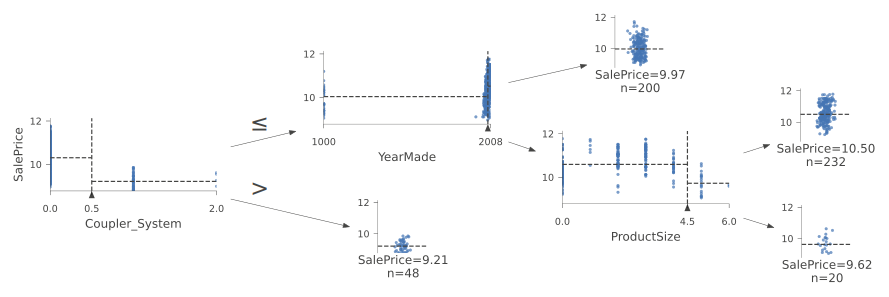

In [44]:
samp_idx = np.random.permutation(len(y))[:500]
# The book's Decision Tree visualizer i.e. dtreeviz() has been deprecated
# Use the following instead
viz_model = dtv.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx],
                      feature_names=xs.columns, target_name=dep_var)
viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

Something is clearly off with our `YearMade` data, where the year 1000 seems to exist for a number of instances. The authors of the book presume that this is a missing value code / placeholder for missing info.

We can replace this with 1950.

In [48]:
xs.loc[xs['YearMade'] < 1950, 'YearMade']= 1950
valid_xs.loc[valid_xs['YearMade'] < 1950, 'YearMade'] = 1950

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


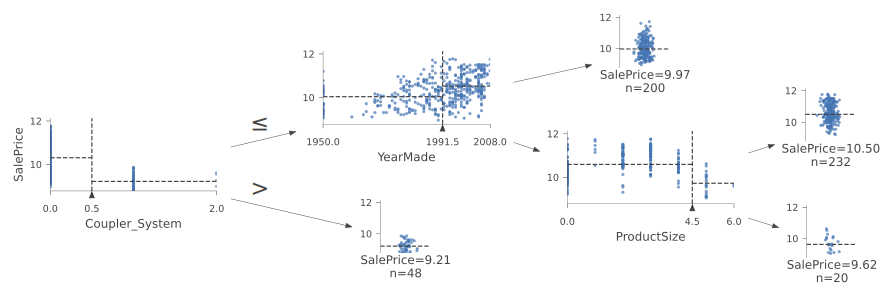

In [49]:
# Retraining the model and replotting
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
# Using the updated dtreeviz code from before
viz_model = dtv.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx],
                      feature_names=xs.columns, target_name=dep_var)
viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

In [50]:
# Creating a bigger decision tree without limiting parameters.
m = DecisionTreeRegressor()
m.fit(xs, y);

In [51]:
# Creating a function to check the RMSE
def r_mse(pred, y):
  return round(math.sqrt(((pred - y)**2).mean()), 6)

def m_rmse(model, xs, y):
  return r_mse(model.predict(xs), y)

In [52]:
m_rmse(m, valid_xs, valid_y)

0.331894

Clearly indicating that we are overfitting.

The number of leaf nodes below is almost equal to the number of data points. This is the direct result of not having implemented a limit to the minimum number of items in each leaf node.

In [53]:
m.get_n_leaves(), len(xs)

(324570, 404710)

In [54]:
# Using sklearn's default setting.
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248584, 0.323356)

In [55]:
m.get_n_leaves()

12397